In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-claims/fully_paid_claims.csv
/kaggle/input/medical-claims/unpaid_claims.csv
/kaggle/input/medical-claims/partially_paid_claims.csv


In [100]:
# Read in each separate dataset
df1 = pd.read_csv('/kaggle/input/medical-claims/fully_paid_claims.csv')
df2 = pd.read_csv('/kaggle/input/medical-claims/partially_paid_claims.csv')
df3 = pd.read_csv('/kaggle/input/medical-claims/unpaid_claims.csv')

# Combine the datasets into one dataframe, and shuffle them so the label ordering is randomized
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-100-caeb33c91f88>:2: DtypeWarning: Columns (7,8,42,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/kaggle/input/medical-claims/fully_paid_claims.csv')
<ipython-input-100-caeb33c91f88>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/kaggle/input/medical-claims/partially_paid_claims.csv')
<ipython-input-100-caeb33c91f88>:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/kaggle/input/medical-claims/unpaid_claims.csv')


In [101]:
print(shuffled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   bill_selection_date            750000 non-null  object 
 1   bill_id                        750000 non-null  int64  
 2   bill_detail_id                 750000 non-null  int64  
 3   line_number                    750000 non-null  int64  
 4   hcpcs_line_procedure_billed    750000 non-null  object 
 5   first_hcpcs_modifier_billed    306034 non-null  object 
 6   second_hcpcs_modifier_billed   50160 non-null   object 
 7   third_hcpcs_modifier_billed    358 non-null     object 
 8   fourth_hcpcs_modifier_billed   10 non-null      object 
 9   procedure_description          256606 non-null  object 
 10  total_charge_per_line          750000 non-null  float64
 11  days_units_code                750000 non-null  object 
 12  days_units_billed             

In [102]:
#Drop columns that provide information about what happened after the initial submission
shuffled_df.drop(columns=['number_of_service_adjustments','days_units_paid', 'hcpcs_line_procedure_paid', 'first_hcpcs_modifier_paid', 'second_hcpcs_modifier_paid', 'third_hcpcs_modifier_paid', 'fourth_hcpcs_modifier_paid'], inplace=True)
shuffled_df = shuffled_df.drop(columns=[col for col in shuffled_df.columns if "service_adjustment_" in col])

In [103]:
# Change the date formats, and extract relevant information about the billing and service months (it was determined that day of week was not relevant to the target)
shuffled_df['date'] = pd.to_datetime(shuffled_df['bill_selection_date'])

shuffled_df['bill_month'] = shuffled_df['date'].dt.month

shuffled_df['service_start'] = pd.to_datetime(shuffled_df['service_line_from_date'])
shuffled_df['service_end'] = pd.to_datetime(shuffled_df['service_line_to_date'])

shuffled_df['start_month'] = shuffled_df['service_start'].dt.month

shuffled_df['end_month'] = shuffled_df['service_end'].dt.month

shuffled_df.drop(columns=['date', 'bill_selection_date', 'service_start', 'service_end'], inplace=True)
shuffled_df.drop(columns=['service_line_from_date', 'service_line_to_date'], inplace=True)

In [104]:
# Separate HCPCS code prefix from numeric part

shuffled_df['hcpcs_numeric'] = shuffled_df['hcpcs_line_procedure_billed'].str.extract(r'(\d+)', expand=False).astype(float)

shuffled_df['hcpcs_prefix'] = shuffled_df['hcpcs_line_procedure_billed'].str.extract(r'([A-Za-z]+)', expand=False).fillna('None')
shuffled_df['hcpcs_prefix_encoded'] = shuffled_df['hcpcs_prefix'].astype('category').cat.codes

shuffled_df.drop(columns=['hcpcs_line_procedure_billed', 'hcpcs_prefix'], inplace=True)

In [105]:
# Frequency encode the HCPCS modifier codes

freq_encoding = shuffled_df['first_hcpcs_modifier_billed'].value_counts().to_dict()
shuffled_df['first_hcpcs_modifier_encoded'] = shuffled_df['first_hcpcs_modifier_billed'].map(freq_encoding)
shuffled_df['first_hcpcs_modifier_encoded'] = shuffled_df['first_hcpcs_modifier_encoded'].fillna(0)

freq_encoding = shuffled_df['second_hcpcs_modifier_billed'].value_counts().to_dict()
shuffled_df['second_hcpcs_modifier_encoded'] = shuffled_df['second_hcpcs_modifier_billed'].map(freq_encoding)
shuffled_df['second_hcpcs_modifier_encoded'] = shuffled_df['second_hcpcs_modifier_encoded'].fillna(0)

freq_encoding = shuffled_df['third_hcpcs_modifier_billed'].value_counts().to_dict()
shuffled_df['third_hcpcs_modifier_encoded'] = shuffled_df['third_hcpcs_modifier_billed'].map(freq_encoding)
shuffled_df['third_hcpcs_modifier_encoded'] = shuffled_df['third_hcpcs_modifier_encoded'].fillna(0)

freq_encoding = shuffled_df['fourth_hcpcs_modifier_billed'].value_counts().to_dict()
shuffled_df['fourth_hcpcs_modifier_encoded'] = shuffled_df['fourth_hcpcs_modifier_billed'].map(freq_encoding)
shuffled_df['fourth_hcpcs_modifier_encoded'] = shuffled_df['fourth_hcpcs_modifier_encoded'].fillna(0)

shuffled_df.drop(columns=['first_hcpcs_modifier_billed','second_hcpcs_modifier_billed', 'third_hcpcs_modifier_billed', 'fourth_hcpcs_modifier_billed'], inplace=True)

In [106]:
# Drop text-based feature for now
shuffled_df.drop(columns=['procedure_description'], inplace=True)

In [107]:
# Encode the unit of service (days vs minutes)
shuffled_df = pd.get_dummies(shuffled_df, columns=['days_units_code'], prefix='unit', dummy_na=True)

In [108]:
# Encode the CRNA supervision
shuffled_df['crna_supervised_encoded'] = shuffled_df['crna_supervision_indicator'].map({'Y': 1, 'N': 0}).fillna(0)

shuffled_df.drop(columns=['crna_supervision_indicator'], inplace=True)

In [109]:
# Encode the provider line agreement code (PPO agreement, participation agreement, no agreement, NAN)
shuffled_df = pd.get_dummies(shuffled_df, columns=['provider_agreement_line_code'], prefix='provider', dummy_na=True)

In [110]:
# Encode treatment auth (reported or not reported)
shuffled_df['treatment_auth_encoded'] = shuffled_df['treatment_line_authorization'].map({'Y': 1, 'N': 0}).fillna(0)
shuffled_df.drop(columns=['treatment_line_authorization'], inplace=True)

In [111]:
shuffled_df.replace('None', np.nan, inplace=True)

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


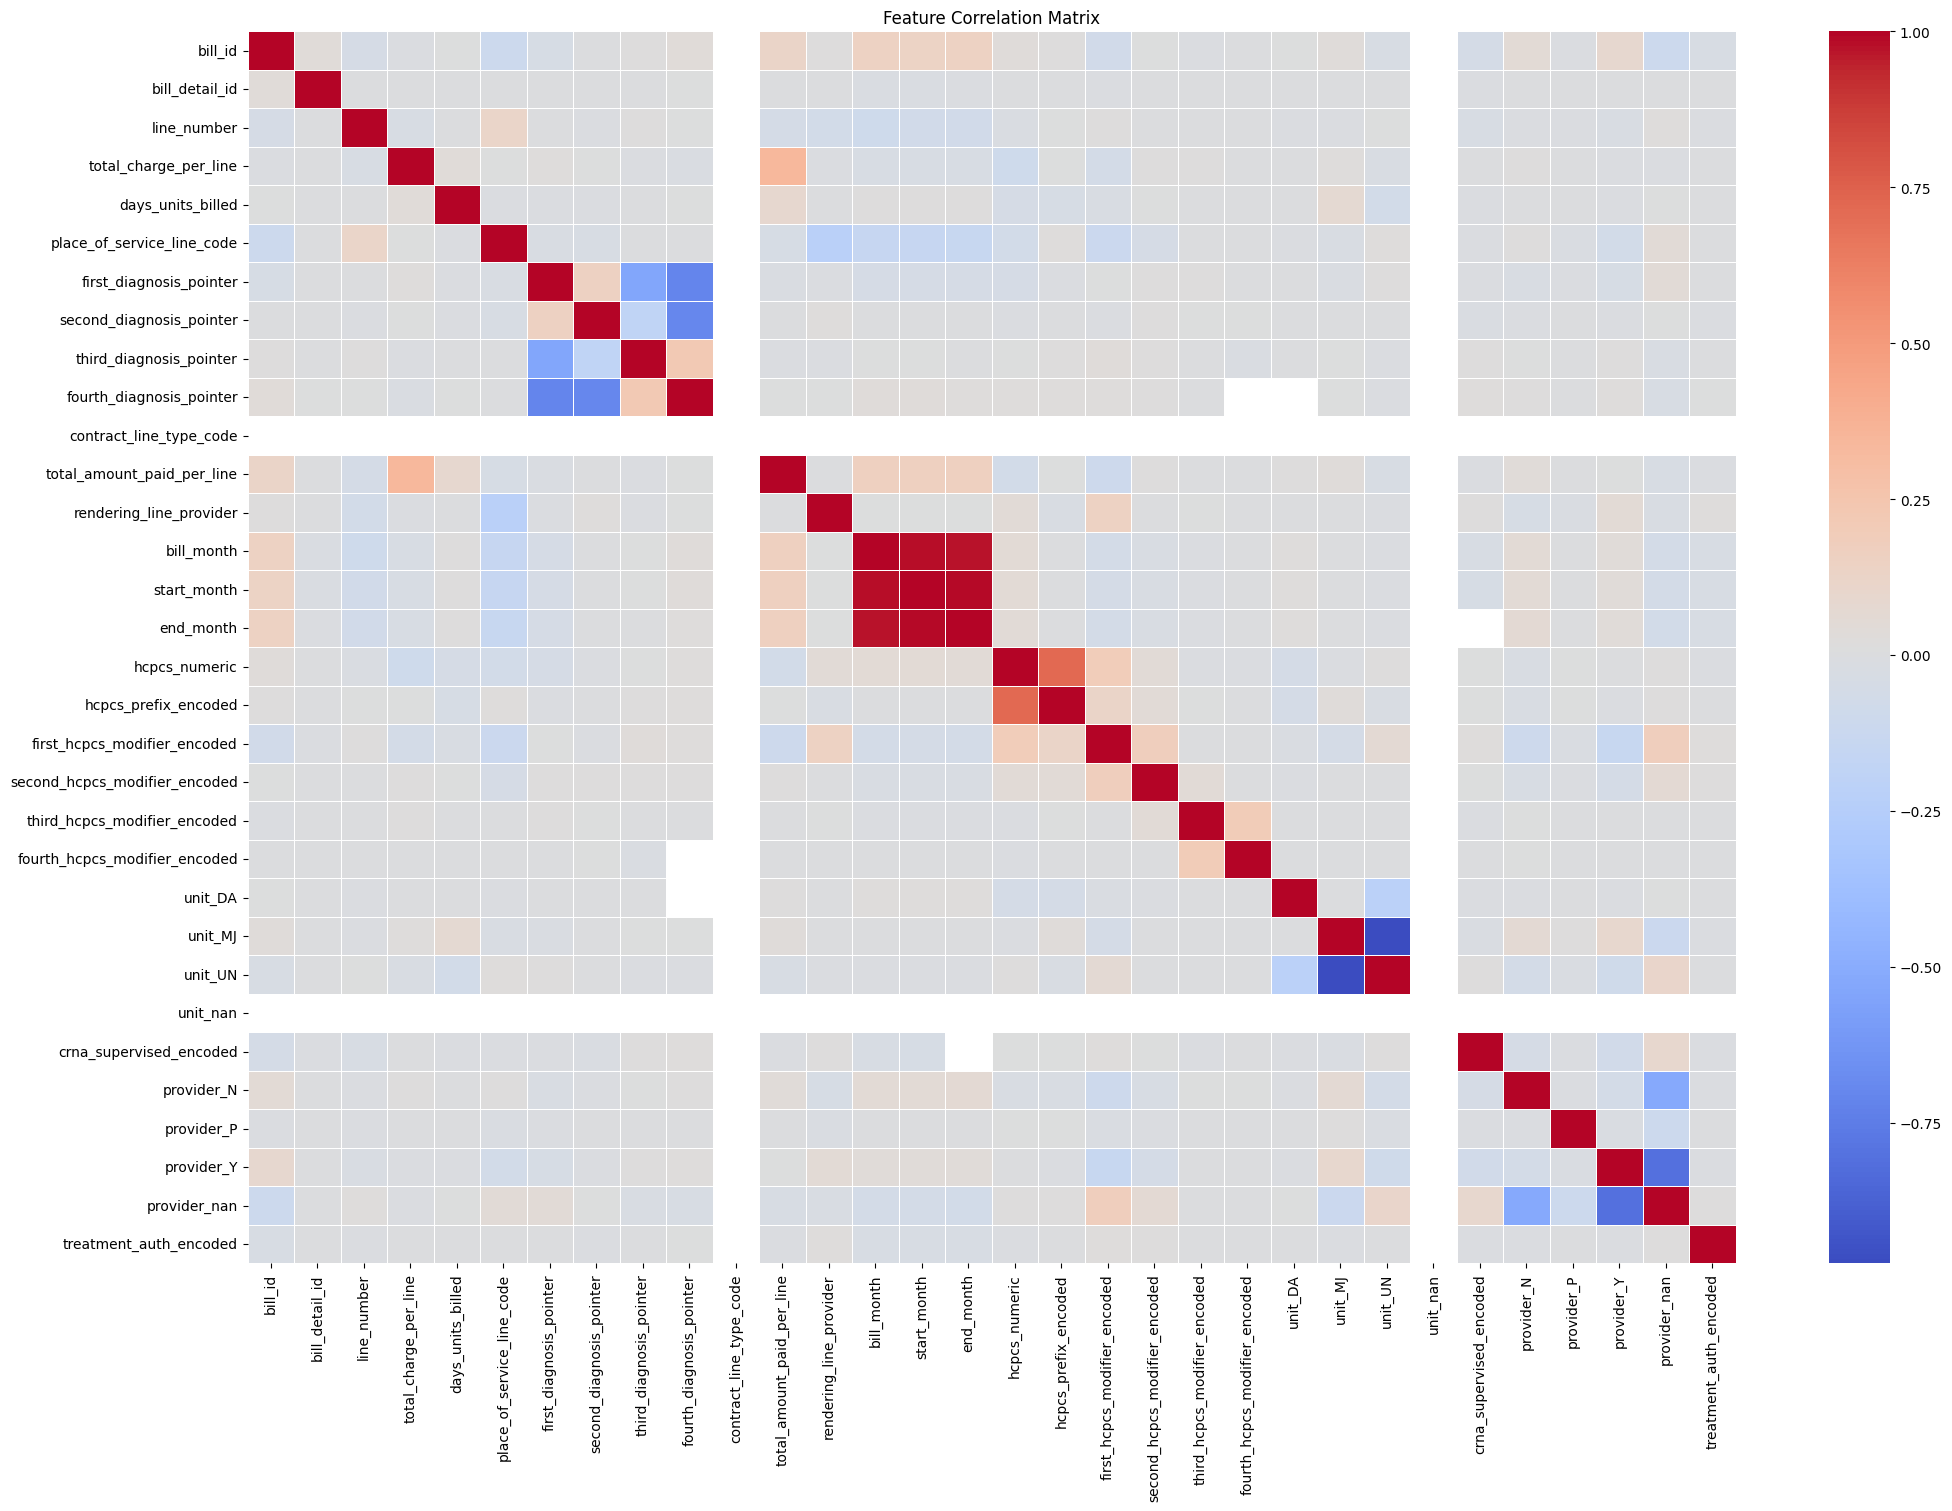

In [112]:
# Plot a heatmap of all of the correlations
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = shuffled_df.corr()

plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [113]:
# Correlations for the target variable
print(corr_matrix['total_amount_paid_per_line'].sort_values(ascending=False))

total_amount_paid_per_line       1.000000
total_charge_per_line            0.340253
bill_month                       0.163663
start_month                      0.160737
end_month                        0.160572
bill_id                          0.123723
days_units_billed                0.086080
provider_N                       0.041068
unit_MJ                          0.030098
second_hcpcs_modifier_encoded    0.017923
unit_DA                          0.013135
provider_Y                       0.010402
hcpcs_prefix_encoded             0.008497
fourth_diagnosis_pointer         0.006485
bill_detail_id                   0.002064
second_diagnosis_pointer         0.000500
fourth_hcpcs_modifier_encoded   -0.000794
provider_P                      -0.001707
third_hcpcs_modifier_encoded    -0.001741
rendering_line_provider         -0.002390
third_diagnosis_pointer         -0.006017
crna_supervised_encoded         -0.006096
treatment_auth_encoded          -0.009764
first_diagnosis_pointer         -0

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


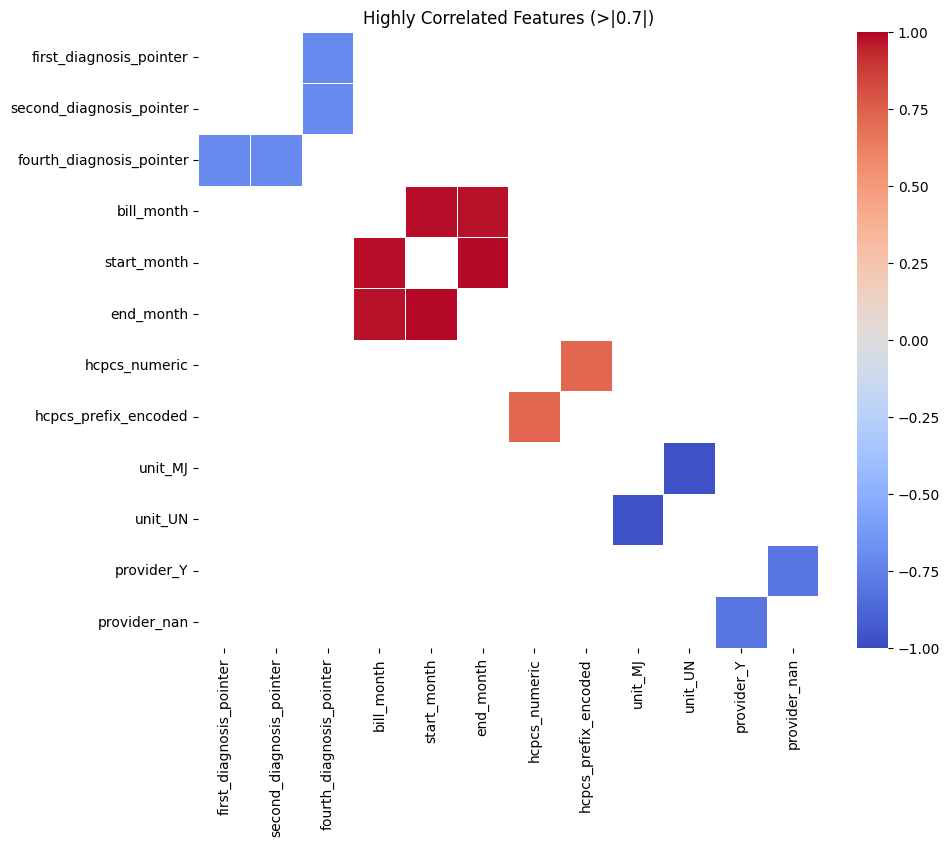

In [114]:
# Heatmap for highly correlated features
threshold = 0.7

high_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]
np.fill_diagonal(high_corr.values, np.nan)
high_corr = high_corr.dropna(how='all').dropna(axis=1, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(high_corr, annot=False, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Highly Correlated Features (>|0.7|)")
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


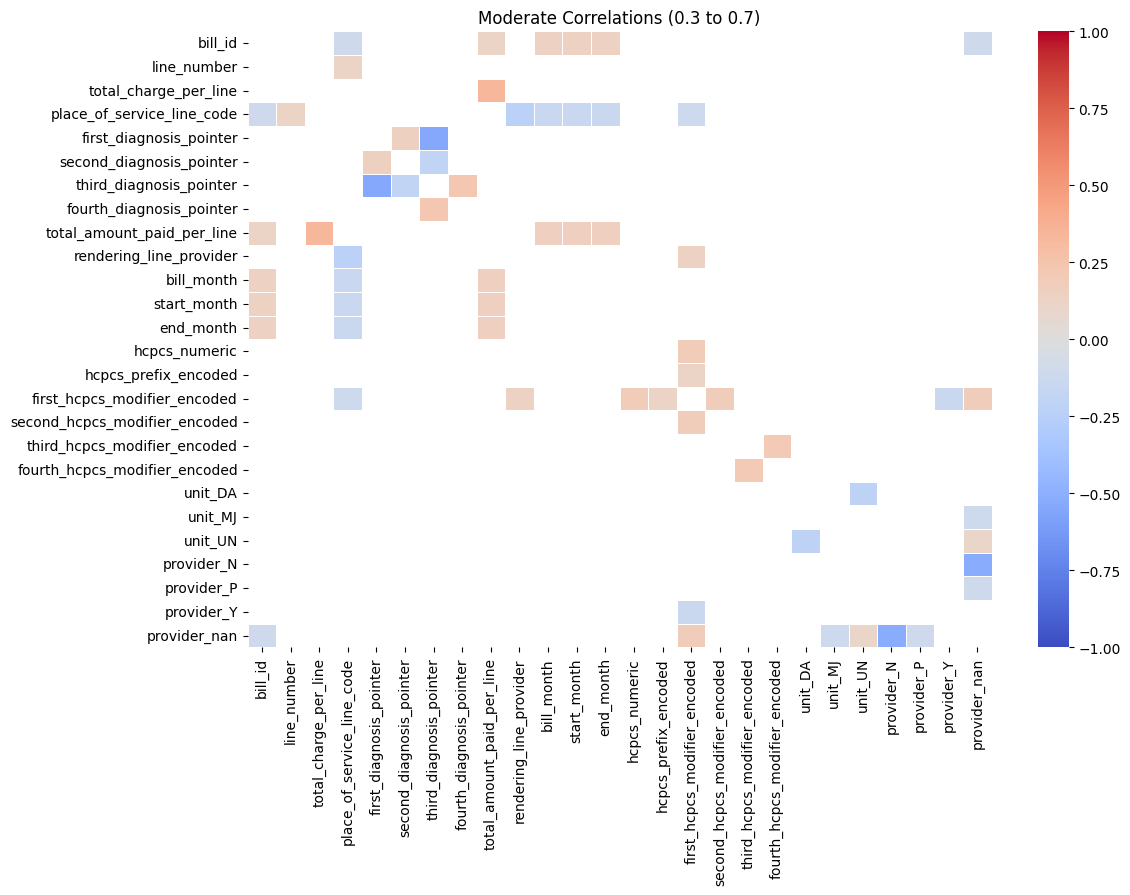

In [115]:
# Heatmap for medium-correlated features
lower_threshold = 0.1
upper_threshold = 0.7

medium_corr = corr_matrix[
    ((corr_matrix >= lower_threshold) & (corr_matrix <= upper_threshold)) |
    ((corr_matrix <= -lower_threshold) & (corr_matrix >= -upper_threshold))
]

np.fill_diagonal(medium_corr.values, np.nan)

medium_corr = medium_corr.dropna(how='all').dropna(axis=1, how='all')

plt.figure(figsize=(12, 8))
sns.heatmap(medium_corr, annot=False, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Moderate Correlations (0.3 to 0.7)")
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


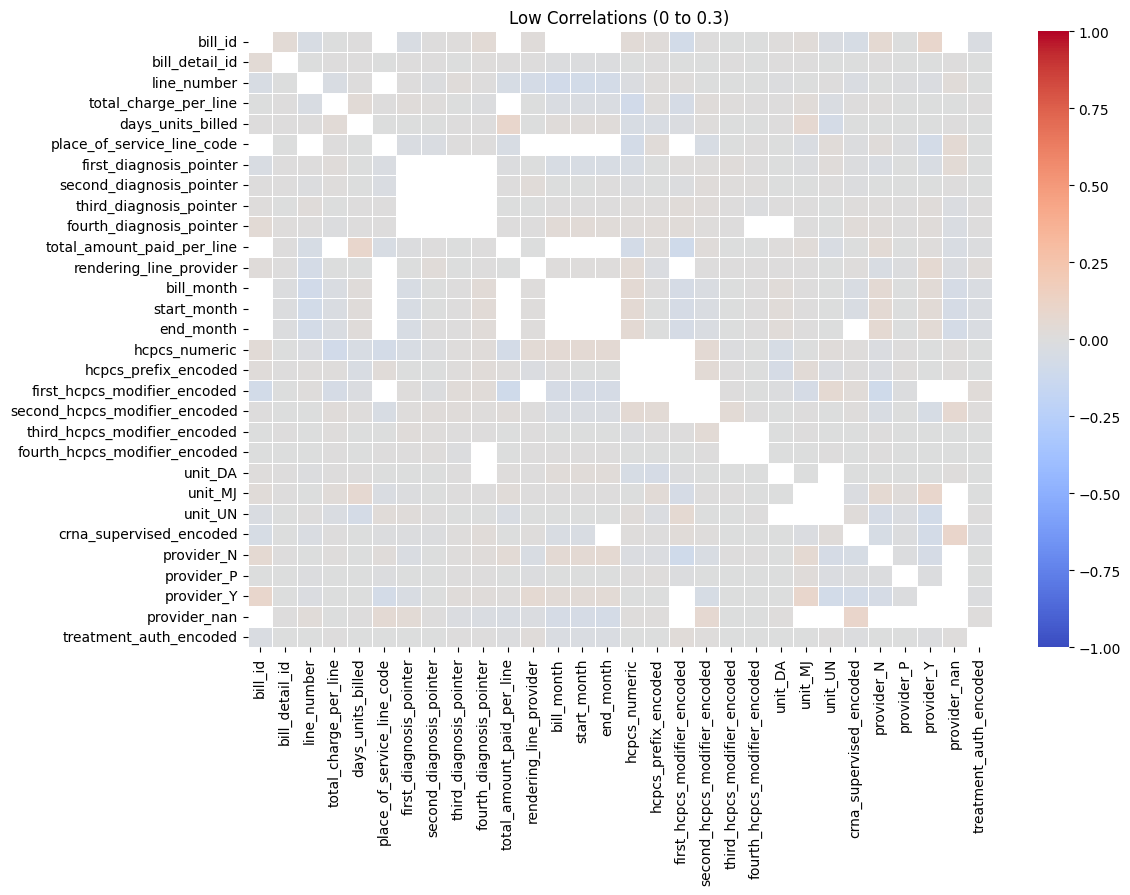

In [116]:
# Heatmap for low correlated features
lower_threshold = 0
upper_threshold = 0.1

medium_corr = corr_matrix[
    ((corr_matrix >= lower_threshold) & (corr_matrix <= upper_threshold)) |
    ((corr_matrix <= -lower_threshold) & (corr_matrix >= -upper_threshold))
]

np.fill_diagonal(medium_corr.values, np.nan)

medium_corr = medium_corr.dropna(how='all').dropna(axis=1, how='all')

plt.figure(figsize=(12, 8))
sns.heatmap(medium_corr, annot=False, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Low Correlations (0 to 0.3)")
plt.show()

In [ ]:
# Drop columns that are not very correlated to target, highly correlated to others, and have a lot of missing values
# NOTE: we could get more information on the provider from rendering_line_provider, but the actual NPI is not useful for the model, there is an API that could be used to get their specialty etc.
shuffle_df.drop(columns=['bill_id', 'bill_detail_id', 'line_number', 'crna_supervised_encoded', 'hcpcs_prefix_encoded', 'rendering_line_provider'], inplace=True)